In [1]:
%load_ext autoreload
%autoreload 2

# Rectangular regional CESM-MOM6 run to capture the Pacific Cold Tongue

A workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain: horizontal grid, bathymetry, vertical grid
2. Create the CESM case: uses visualCaseGen behind the scenes to configure the CESM case with CIME
3. Prepare ocean forcing data: we need tidal data (TXPO), initial fields/tracers (GLORYS), and boundary conditions (GLORYS)
4. Build and run the case: uses scripts in the CESM case, not done within the notebook. 


## 1. Initialize Grids from Files

Here we are generating new versions of the horizontal grid, vertical grid, and bathymetry from existing files. If you load from files, it is important to ensure that the bathymetry was regridded on the same horizontal grid you load. 

Making the horizontal and vertical grids is a very cheap step, but regridding the bathymetry and later regridding the forcings can be more computationally expensive (and a little annoying). Thus, unless you need change the horizontal grid or vertical grid (i.e. different resolution or spatial extent), it is best to reuse past grids with already regridded bathymetry and forcings. 

Summary of the dependencies:
- Change Horizontal Grid -> must regrid bathymetry and forcings
- Change Vertical Grid -> must regrid forcings (bathymetry unaffected). 

In [2]:
from CrocoDash.grid import Grid

hgrid_path = '/glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue_archive/ocnice/ocean_hgrid_PacificColdTongue.nc'
hgrid = Grid.from_supergrid(path=hgrid_path)
hgrid.name = 'PacificColdTongue0006'

In [3]:
from CrocoDash.topo import Topo

topo_path = '/glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue_archive/ocnice/ocean_topog_PacificColdTongue.nc'
topo = Topo.from_topo_file(grid = hgrid, topo_file_path=topo_path, min_depth = 5) # setting minimum depth can be changed with topo editor. 

In [ ]:
from CrocoDash.vgrid import VGrid

vgrid_path = '/glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue_archive/ocnice/ocean_vgrid_PacificColdTongue.nc'
vgrid = VGrid.from_file(filename=vgrid_path) # z* grid defined from a tanh function

# Generate your own!
# vgrid  = VGrid.hyperbolic(
#     nk = 75,
#     depth = topo.max_depth,
#     ratio=20.0
# )

### Optional: Edit Bathymetry & Visualize Vertical Grid

The topo editor lets you adjust minimum depth, erase basins, and edit individual cell depth. Use the rectangular icon in the upper right to draw a box and zoom in on different parts of the domain. Double click on a cell to select it and change the depth. 

Any changes you make in the topo editor will not change the original topo file. The changes will temporarily be stored in the Topo object, and then they will be saved in a new netCDF file when we create the case in part 2. 

In [5]:
%matplotlib ipympl
from CrocoDash.topo_editor import TopoEditor

topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

In [6]:
# Optional Manual Mask
# topo.depth = topo.depth[topo.depth < 4000]

The vertical grid is defined from a tanh function. Here we can visually examine the shape and the approximate thickness. We can also consider if we want the vertical grid to have similar thickness all the way to the deepest depth in the domain (an anomalously deep trench in this case). It is a z* grid.

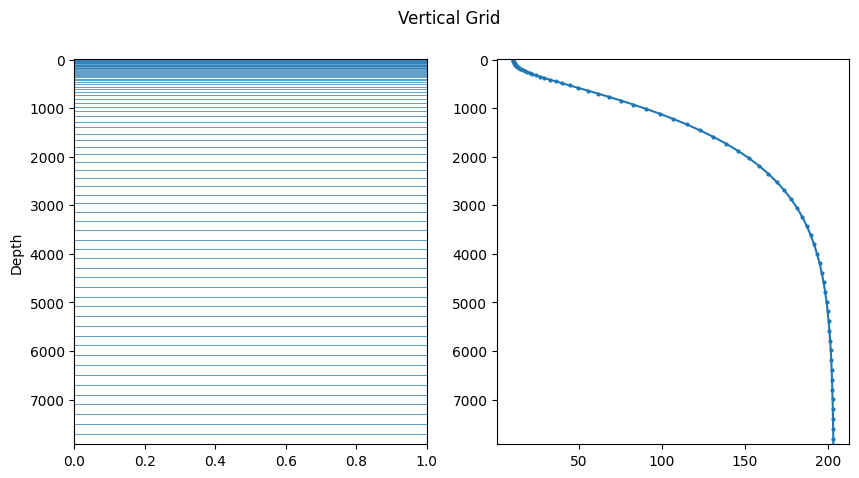

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.close()

fig, ax = plt.subplots(1,2, figsize=(10,5))

# Create the plot
for depth in vgrid.z:
    ax[0].axhline(y=depth, linestyle='-', linewidth=0.5)  # Horizontal lines

ax[0].set_ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)  # Invert y-axis so deeper values go down
ax[0].set_ylabel("Depth")

ax[1].plot(vgrid.dz,np.cumsum(vgrid.dz),'o-', markersize=2)
ax[1].set_ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)

fig.suptitle("Vertical Grid")
plt.show()

## 2. Create CESM Case
Reccomend not overidding a previous case. If you want to reuse an input directory without copying the forcing and grid files, you can edit the `user_nl_mom` file in the case directory to point towards another directory. There is a bug when we set override=False. Alper and Manish are currently addressing it. I would reccomend duplicating and saving any previous case input that is valuable just in case. 

In [8]:
from pathlib import Path

# CESM case (experiment) name
casename = "pacific_cold_tongue_0006" # recommend correlating with the hgrid name above

# CESM source root (Update this path accordingly!!!)
cesmroot = '/glade/work/ajanney/CESM-versions/CROC_CESM'

# Place where all your input files go 
inputdir = Path("/glade/work/ajanney/CrocoDash_Input",casename) 
    
# CESM case directory
caseroot = Path("/glade/work/ajanney/CESM/cases",casename)

project_code = 'P93300012'

In [9]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = hgrid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = project_code,
    machine="derecho",
    override = True, 
    ## This will override an existing directory, so be careful. 
    ## There is a bug when we set override=False. Alper and Manish are currently addressing it. 
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "pacific_cold_tongue_0006" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "PacificColdTongue0006".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "PacificColdTongue0006" with the following properties:
 nx: 960, ny: 288. ocean mesh: /glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue_0006/ocnice/ESMF_mesh_PacificColdTongue0006_7609fb.nc.

Running the create_newcase tool with the following command:

/glade/work/ajanney/CESM-versions/CROC_CESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res pacific_cold_tongue_0006 --case /glade/work/ajanney/CESM/cases/pacific_cold_tongue_0006 --machine derecho --run-unsupported --project P93300012 --non-local 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/work/ajanney/CESM/cas

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/work/ajanney/CESM/cases/pacific_cold_tongue_0006.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



## 3. Set up Forcings

In [10]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2021-01-01 00:00:00"], # because of a bug right now, set the range one day past your end date.
    tidal_constituents = ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MM', 'MF'],
    tpxo_elevation_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/h_tpxo9.v1.nc",
    tpxo_velocity_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/u_tpxo9.v1.nc",
    product_name = "GLORYS",
    function_name = "get_glorys_data_from_rda", # better if working on NCAR machines
    too_much_data = True,
)

case.process_forcings(
    process_initial_condition = False,
    process_tides = True,
    process_velocity_tracers = False,
) # not necessary to specify arguments as the large data workflow autmatically only processes proper components. Just for clarity.

INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/derecho/scratch/ajanney/tmp/tmpobf91kre/test_file.nc


This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.
Large data workflow was called, please go to the large data workflow path: /glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue_0006/glorys/large_data_workflow and run the driver script there.


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Processing south boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_001
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_001
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing north boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_002
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_002
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing west boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_003
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_003
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing east boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_004
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_004
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Tides
  TIDES = True
  TIDE_M2 = True
  CD_TIDES = 0.0018
  TIDE_USE_EQ_PHASE = True
  TIDE_REF_DATE = 2020, 1, 1
  OBC_TIDE_ADD_EQ_PHASE = True
  OBC_TIDE_N_CONSTITUENTS = 10
  OBC_TIDE_CONSTITUENTS = "M2, S2, N2, K2, K1, O1, P1, Q1, MM, MF"
  OBC_TIDE_REF_DATE = 2020, 1, 1

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY = True
  OBC_COMPUTED_STRAIN = True
  OBC_ZERO_BIHARMONIC = True
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_OUT = 3.0E+04
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_IN = 3000.0


## 4. Finish Large Data Workflow
The large data workflow should populate the OBCs and initial conditions for your region. The tides were procesed by the above call. 

1. Adjust the `large_data_workflow_derecho.sh` or `large_data_workflow_casper.sh` scripts in this directory with the correct:
      - Project Code
      - Large data workflow path (see print output of the previous cell). 
2. Submit the script `qsub large_data_workflow_derecho.sh` or `qsub large_data_workflow_casper.sh` depending on the system your on (there is also the interacive process we did before, but it's complicated.)
      - The resource requests for these scripts are just estimates. Change them as you see fit **or if you are requesting a lot of data**
      - Rule of thumb(ish): 1 year of data for cold tongue region takes: 1 hour to 1.25 hours
3. Then you should check the input directory and the `ocnice` folder to make sure the following files are present:
      - init_vel.nc, init_eta.nc, init_tracers.nc
      - forcing_obc_segment_001-4.nc

## 5. Build and Run the CESM Case and make any adjustments!

Change to your CESM case and run: `./case.build && ./case.submit`